# Аналитика Я.Афиши для оптимизации маркетинговых затрат

Необходимо провести исследование, которое поможет маркетологам оптимизировать маркетинговые затраты. 

В нашем распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Необходимо изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент, 
- когда клиент окупается.

## Описание данных

**Таблица visits (лог сервера с информацией о посещениях сайта):**
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

**Таблица orders (информация о заказах):**
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

**Таблица costs (информация о затратах на маркетинг):**
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день



## План работы: 

Шаг 1. Изучение общей информации о файлах и их подготовка к анализу

Шаг 2. Посчитать метрики и простроить отчеты

**Продукт**
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

**Продажи**
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

**Маркетинг**
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)

Шаг 3. Вывод


###  Шаг 1. Изучим информация о файлах и подготовим их к анализу

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from matplotlib import pyplot

Изучим датасет visits_log.csv:

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')

visits.info()

visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


В таблицу visits колонки Start Ts, End Ts необходимо привести к типу datetime, кроме того, колонку Source Id необходимо переименовать, чтобы ее название совпадало с названием колонки source_id в costs.

In [3]:
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits = visits.rename(columns = {'Source Id':'source_id'})

visits.info()
visits.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
Start Ts     359400 non-null datetime64[ns]
Uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,source_id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062


Изучим датасет orders_log.csv:

In [4]:
orders = pd.read_csv('/datasets/orders_log.csv')

orders.info()

orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


В таблице orders колонку Buy Ts необходимо привести к типу datetime:

In [5]:
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null datetime64[ns]
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


Изучим датасет costs.csv:

In [6]:
costs = pd.read_csv('/datasets/costs.csv')

costs.info()

costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


В таблице costs колонку dt необходимо привести к типу datetime:

In [7]:
costs['dt'] = pd.to_datetime(costs['dt'])

costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


###  Шаг 2. Посчитаем метрики и построим отчеты

#### 2.1 Продукты

 2.1.1 Сколько людей пользуются в день, неделю, месяц?
 
Для этого рассчитаем средние метрики DAU, WAU, MAU в разрезе по рекламным источникам и используемым девайсам:

In [8]:
#чтобы посчитать недельное и месячное использование, выделим в отдельные столбцы год, месяц и неделю, а также полную дату.

visits['session_year']  = visits['Start Ts'].dt.year
visits['session_month'] = visits['Start Ts'].dt.month
visits['session_week']  = visits['Start Ts'].dt.week
visits['session_date'] = visits['Start Ts'].dt.date

visits.head()

,Device,End Ts,source_id,Start Ts,Uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


DAU

In [9]:
#посчитаем среднее количество уникальных пользователей Я.Афиша в день:
dau_total = visits.groupby('session_date').agg({'Uid': 'nunique'}).mean()

print('DAU:', int(dau_total))

DAU: 907


[Text(0, 0.5, 'среднее DAU'), Text(0.5, 0, 'ID рекламного источника')]

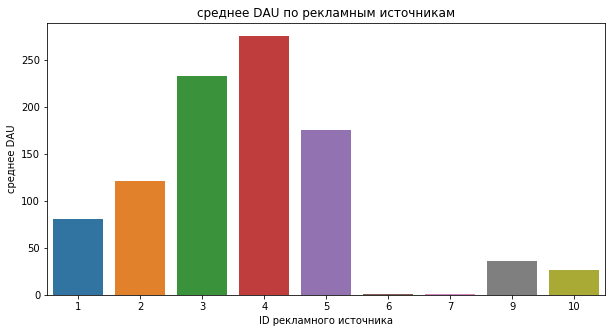

In [10]:
#dau по рекламным источникам
sources_dau = visits.groupby(['source_id','session_date']).agg({'Uid': 'nunique'}).groupby(
    ['source_id']).agg({'Uid': 'mean'})

sources_dau = sources_dau.reset_index()

fig, ax = pyplot.subplots(figsize=(10, 5))

sns.barplot(x='source_id', y='Uid', data=sources_dau)
ax.set_title('среднее DAU по рекламным источникам')
ax.set(xlabel='ID рекламного источника', ylabel='среднее DAU')

[Text(0, 0.5, 'среднее DAU'), Text(0.5, 0, 'Используемое устройство')]

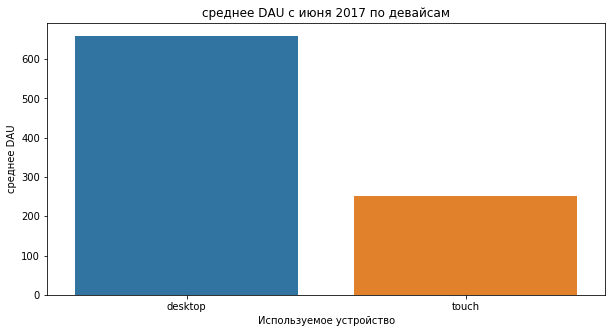

In [11]:
#dau по девайсам
sources_dau = visits.groupby(['Device','session_date']).agg({'Uid': 'nunique'}).groupby(
    ['Device']).agg({'Uid': 'mean'})

sources_dau = sources_dau.reset_index()

fig, ax = pyplot.subplots(figsize=(10, 5))

sns.barplot(x='Device', y='Uid', data=sources_dau)
ax.set_title('среднее DAU с июня 2017 по девайсам')
ax.set(xlabel='Используемое устройство', ylabel='среднее DAU')

WAU

In [12]:
#посчитаем среднее количество уникальных пользователей Я.Афиша в неделю:
wau_total = visits.groupby(['session_year', 'session_week']).agg({'Uid': 'nunique'}).mean()

print('WAU', int(wau_total)) 

WAU 5716


[Text(0, 0.5, 'среднее WAU'), Text(0.5, 0, 'ID рекламного источника')]

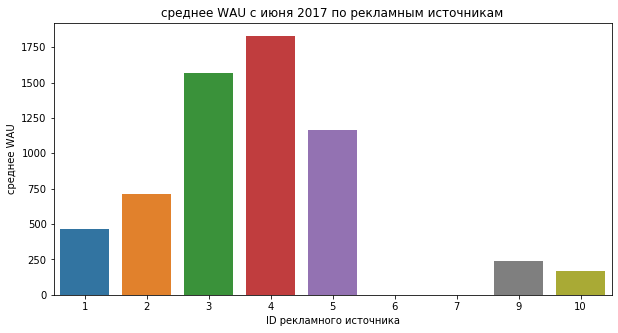

In [13]:
#wau по рекламным источникам

sources_wau = visits.groupby(['source_id','session_year', 'session_week']).agg({'Uid': 'nunique'}).groupby(
    ['source_id']).agg({'Uid': 'mean'})

sources_wau = sources_wau.reset_index()

fig, ax = pyplot.subplots(figsize=(10, 5))

sns.barplot(x='source_id', y='Uid', data=sources_wau)
ax.set_title('среднее WAU с июня 2017 по рекламным источникам')
ax.set(xlabel='ID рекламного источника', ylabel='среднее WAU')

[Text(0, 0.5, 'среднее WAU'), Text(0.5, 0, 'Используемое устройство')]

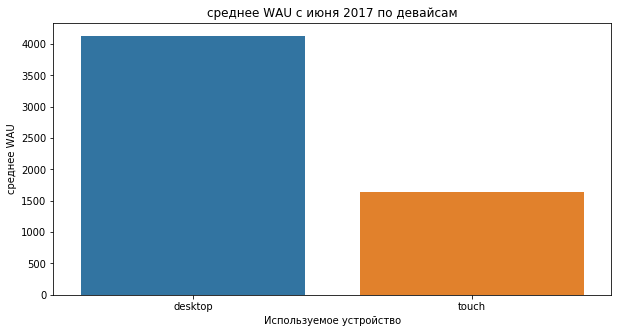

In [14]:
#wau по девайсам

sources_wau = visits.groupby(['Device', 'session_year', 'session_week']).agg({'Uid': 'nunique'}).groupby(
    ['Device']).agg({'Uid': 'mean'})

sources_wau = sources_wau.reset_index()

fig, ax = pyplot.subplots(figsize=(10, 5))

sns.barplot(x='Device', y='Uid', data=sources_wau)
ax.set_title('среднее WAU с июня 2017 по девайсам')
ax.set(xlabel='Используемое устройство', ylabel='среднее WAU')

MAU

In [15]:
#посчитаем среднее количество уникальных пользователей Я.Афиша в месяц:
mau_total = visits.groupby(['session_year', 'session_month']).agg({'Uid': 'nunique'}).mean()

print('MAU', int(mau_total))  

MAU 23228


[Text(0, 0.5, 'среднее MAU'), Text(0.5, 0, 'ID рекламного источника')]

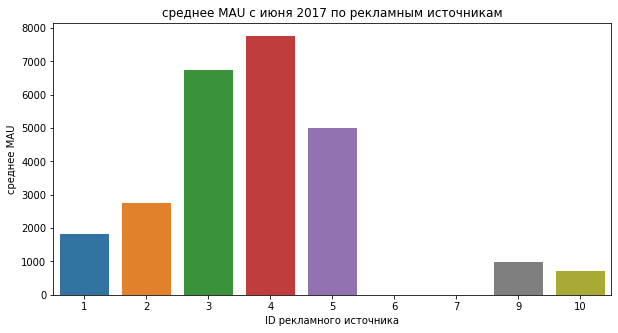

In [16]:
#wau по рекламным источникам

sources_mau = visits.groupby(['source_id', 'session_year', 'session_month']).agg({'Uid': 'nunique'}).groupby(
    ['source_id']).agg({'Uid': 'mean'})

sources_mau = sources_mau.reset_index()

fig, ax = pyplot.subplots(figsize=(10, 5))

sns.barplot(x='source_id', y='Uid', data=sources_mau)
ax.set_title('среднее MAU с июня 2017 по рекламным источникам')
ax.set(xlabel='ID рекламного источника', ylabel='среднее MAU')

[Text(0, 0.5, 'среднее MAU'), Text(0.5, 0, 'Используемое устройство')]

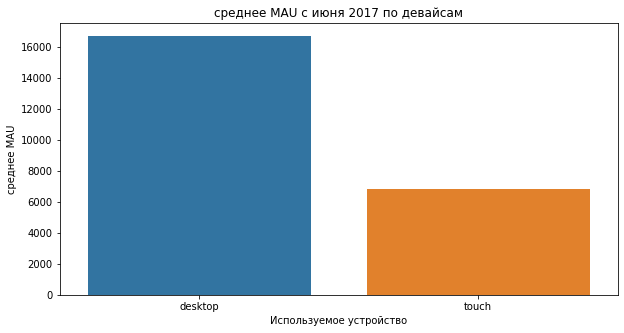

In [17]:
#mau по девайсам

sources_mau = visits.groupby(['Device', 'session_year', 'session_month']).agg({'Uid': 'nunique'}).groupby(
    ['Device']).agg({'Uid': 'mean'})

sources_mau = sources_mau.reset_index()

fig, ax = pyplot.subplots(figsize=(10, 5))

sns.barplot(x='Device', y='Uid', data=sources_mau)
ax.set_title('среднее MAU с июня 2017 по девайсам')
ax.set(xlabel='Используемое устройство', ylabel='среднее MAU')

В среднем Я.Афишей пользуются 907 человек в день, 5716 в неделю, 23228 в месяц.
Большинство пользователей заходят на ресурс с десктопов. 
Независимо от исследуемого периода, большая часть пользователей пришла из рекламных источников 4, 3, 5. 
Меньше всего пользователей привели источники 6 и 7. Либо эти источники не популярны у ЦА Я.Афиши, либо используются недавно.

 2.1.2 Изучим, сколько сессий в день совершают пользователи:

In [18]:
#посчитаем среднее количество сессий в день:
session_average = visits.groupby('session_date').agg({'Uid': 'count'}).median()

print('Среднее количество сессий в день:', int(session_average))

Среднее количество сессий в день: 1003


[Text(0, 0.5, 'кол-во сессий в день'), Text(0.5, 0, 'дата')]

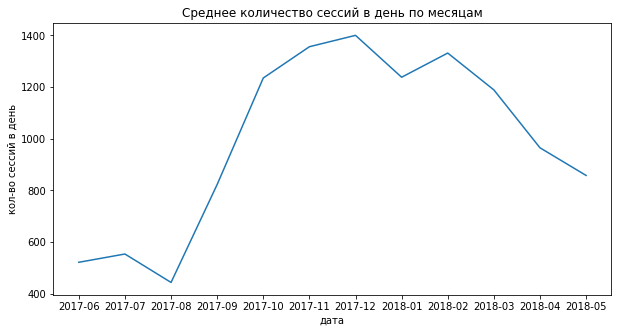

In [19]:
#посмотрим, как менялось среднее количество сессий в день по месяцам:
visits['year_month'] = visits['Start Ts'].dt.strftime('%Y-%m')

monthly_sessions = visits.groupby(['year_month','session_date']).agg({'Uid': 'count'}).groupby(
    ['year_month']).agg({'Uid': 'median'}).reset_index()

fig, ax = pyplot.subplots(figsize=(10, 5))
sns.lineplot(x='year_month', y='Uid', data=monthly_sessions)
ax.set_title('Среднее количество сессий в день по месяцам')
ax.set(xlabel='дата', ylabel='кол-во сессий в день')

Если рассматривать общую картину, то среднее количество сессий в день - 1003. Большая их часть совершается на десктопе. 
Однако, если смотреть на динамику среднего количества сессий в день по месяцам, то видно, что с осени активность пользователей растет - они чаще заходят на Я.Афишу. Пика пользовательская активность достигает в декабре и к весне она снова постепенно снижается.

 2.1.3 Изучим, сколько в среднем длится сессия:

Text(0.5, 1, 'Длительность сессий')

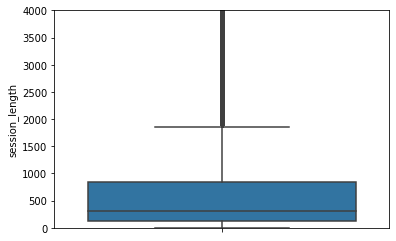

In [20]:
#посчитаем длительность сессий у пользователей в секундах

visits['session_length'] = (visits['End Ts'] - visits['Start Ts']).dt.total_seconds()

#построим график распределения длительности сессий
sns.boxplot(y="session_length", data=visits)
plt.ylim(0, 4000)
ax.set_title('Длительность сессий')

In [21]:
#посчитаем  среднюю длительность сессий как медиану
average_sessions_length = visits['session_length'].median()

print('Средняя длительность сессии:', int(average_sessions_length), 'секунд')

Средняя длительность сессии: 300 секунд


In [22]:
#так как распределение отличается от нормального, посчитаем  среднюю длительность сессий как моду
avg_sessions_length = visits['session_length'].mode()

print('Чаще всего сессия длится:', int(avg_sessions_length), 'секунд')

Чаще всего сессия длится: 60 секунд


Медианная длительность сессии - 300 секунд, это 5 минут. 

Но чаще всего сессия длится 1 минуту. 

Из этого можно сделать вывод, что люди не проводят на сайте много времени - скорее всего заходят целенаправленно. 

Смущает, что 1 минута - самая распространненная длительность сессии. Сложно за минуту выбрать куда пойти и, тем более,купить билет.
Могут это быть боты? Или сервис неудобный? 

 2.1.4 Изучим, как часто люди возвращаются.
 
 Для этого нам нужно построить когорты и рассчитать retention rate.

In [23]:
#найдем дату, когда пользователь впервые проявил активность на Я.Афише:

first_activity_date = visits.groupby(['Uid'])['session_date'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date,on='Uid') 

In [24]:
#выделим первый месяц, когда пользователь был активен
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['activity_month'] = visits['session_date'].astype('datetime64[M]')

In [25]:
#выделим длительность позования сервисом
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = round(visits['cohort_lifetime']).astype('int') 

In [26]:
#построим когорты
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'Uid':'nunique'}).reset_index() 

initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','Uid']]
initial_users_count = initial_users_count.rename(columns={'Uid':'cohort_users'}) 

cohorts = cohorts.merge(initial_users_count,on='first_activity_month') 

cohorts['retention'] = cohorts['Uid']/cohorts['cohort_users'] 

retention_pivot = cohorts[cohorts['cohort_lifetime'] != 0].pivot_table(index='first_activity_month',
                                      columns='cohort_lifetime',
                                      values='retention',aggfunc='sum') 


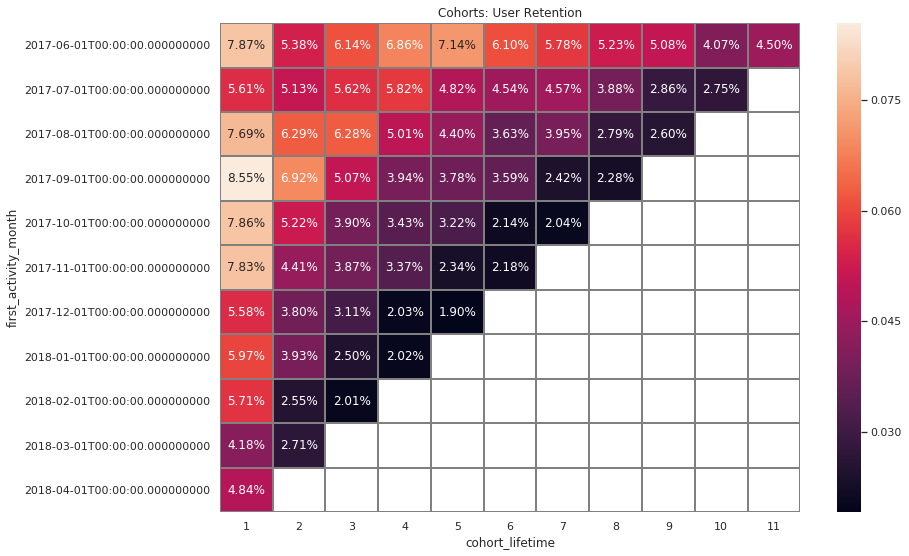

In [27]:
#построим тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='gray'); 

Процент вернувшихся пользователей в каждой когорте очень низкий: более 90% пользователей не возвращаются. Вероятно, пользователи приходили ради конкретного мероприятия, а потом возвращались только те, кто в принципе часто ходит по выставкам/концертам и тд. Или, возможно, дело в том, что в 2017-2018 годах сервис был не очень удобен для планирования досуга.

#### 2.2 Продажи

 2.2.1 Когда люди начинают покупать?


In [28]:
#найдем дату первой покупки для каждого пользователя:
first_order_date = pd.DataFrame(orders.groupby(['Uid'])['Buy Ts'].min()).reset_index()
first_order_date = first_order_date.rename(columns = {'Buy Ts':'first_order_date'})

In [29]:
#объединим данные о первых посещениях и данные первой покупке и посчитаем разницу в днях 

visits_orders = first_order_date.join(first_activity_date,on='Uid') 

visits_orders['first_activity_date'] = pd.to_datetime(visits_orders['first_activity_date']) 

visits_orders['days_to_event'] = ((visits_orders['first_order_date'] - 
                                  visits_orders['first_activity_date'])/ np.timedelta64(1,'D')).astype('int')

In [30]:
print('В среднем люди начинают покупать через',(int(visits_orders['days_to_event'].median())), 'дней')

В среднем люди начинают покупать через 0 дней


Найдем, через сколько минут после первой сессии покупают пользователи:

In [31]:
first_activity_time = visits.groupby(['Uid'])['Start Ts'].min()
first_activity_time.name = 'first_activity_time'
first_order_delay = first_order_date.join(first_activity_time,on='Uid') 

first_order_delay['first_activity_time'] = pd.to_datetime(first_order_delay['first_activity_time']) 

first_order_delay['time_to_event'] = ((first_order_delay['first_order_date'] - 
                                  first_order_delay['first_activity_time'])/ np.timedelta64(1,'m')).astype('int')

In [32]:
print('В среднем люди начинают покупать через',(int(first_order_delay['time_to_event'].median())), 'минут')

В среднем люди начинают покупать через 16 минут


 2.2.2 Сколько раз покупают за период?

In [33]:
#выделим месяц покупки

orders['order_month'] = orders['Buy Ts'].astype('datetime64[M]')

In [34]:
#посчитаем, сколько покупой делает каждый пользователь за месяц и
#посчитаем среднее количество покупок на каждого пользователя за месяц

orders_count = orders.groupby(['order_month', 'Uid'])['Uid'].count()
orders_count.name = 'orders_num'
orders_count = pd.DataFrame(orders_count)
orders_avg = orders_count.pivot_table(
    index='order_month', values='orders_num',aggfunc='median') 

orders_avg

,orders_num
order_month,
2017-06-01,1
2017-07-01,1
2017-08-01,1
2017-09-01,1
2017-10-01,1
2017-11-01,1
2017-12-01,1
2018-01-01,1
2018-02-01,1


В среднем в месяц пользователи делают по одной покупке

[Text(0, 0.5, 'средняя длительность сессии'), Text(0.5, 0, 'дата')]

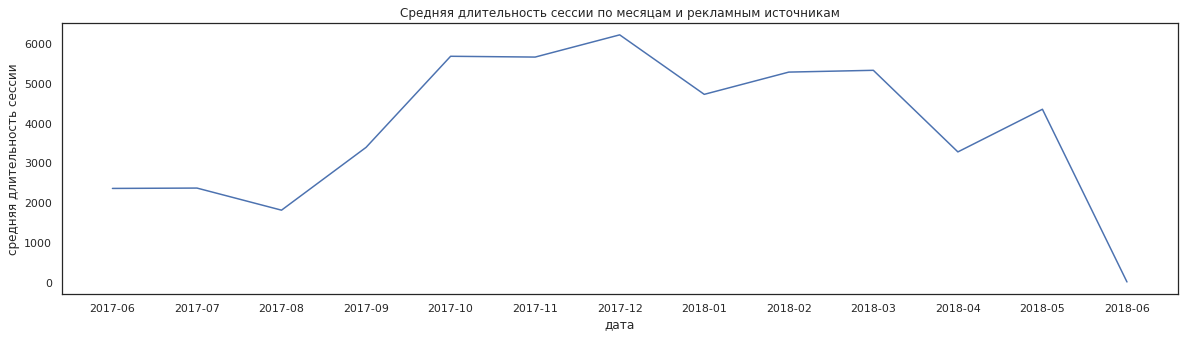

In [35]:
#посчитаем, сколько покупой сделали в месяц в общем: 

orders_total = orders_count.pivot_table(
    index='order_month', values='orders_num',aggfunc='sum').reset_index() 
orders_total['order_month'] = orders_total['order_month'].dt.strftime('%Y-%m')

fig, ax = pyplot.subplots(figsize=(20, 5))
sns.lineplot(x='order_month', y='orders_num', data=orders_total)

ax.set_title('Средняя длительность сессии по месяцам и рекламным источникам')
ax.set(xlabel='дата', ylabel='средняя длительность сессии')

В количестве покупок и тут наблюдается сезонность: больше всего покупают осенью и зимой. 

Посчитаем, сколько покупок делают в месяц по рекламным источникам:

[Text(0, 0.5, 'Количество заказов'), Text(0.5, 0, 'Месяц')]

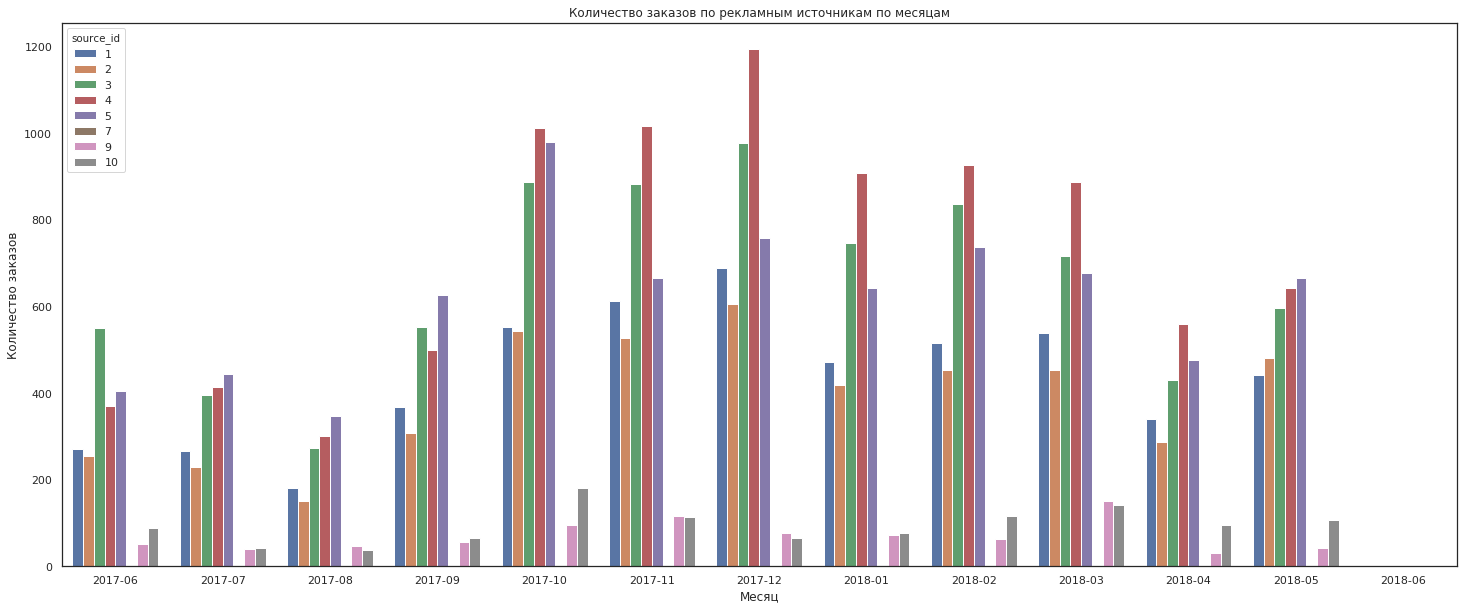

In [36]:
source_orders = visits[['source_id', 'Uid', 'End Ts', 'Start Ts']].merge(orders, on = ['Uid'])

source_orders = source_orders[(source_orders['Start Ts'] <= source_orders['Buy Ts']) & 
              (source_orders['Buy Ts']<= source_orders['End Ts'])]

source_rev = source_orders.pivot_table(
    index=['source_id', 'order_month'], values='Uid',aggfunc='count').reset_index() 
source_rev['order_month'] = source_rev['order_month'].dt.strftime('%Y-%m')

fig, ax = pyplot.subplots(figsize=(25, 10))
sns.barplot(x='order_month', y='Uid', hue = 'source_id', data=source_rev)

ax.set_title('Количество заказов по рекламным источникам по месяцам')
ax.set(xlabel='Месяц', ylabel='Количество заказов')

Чаще всех покупали пользователи трех источников: 4, 5, 3

Реже всех - пользователи 7, 9, 10 источников

 2.2.3 Найдем средний чек 

In [37]:
#посчитаем среднее количество заказов на пользователя
print('Среднее количество заказов на одного пользователя:',orders.groupby('Uid').agg({'Uid': 'count'}).median()[0])

Среднее количество заказов на одного пользователя: 1.0


In [38]:
#найдем средний чек
print('Средний чек -',round(orders['Revenue'].mean(),2))

Средний чек - 5.0


[Text(0, 0.5, 'средний чек'), Text(0.5, 0, 'месяц')]

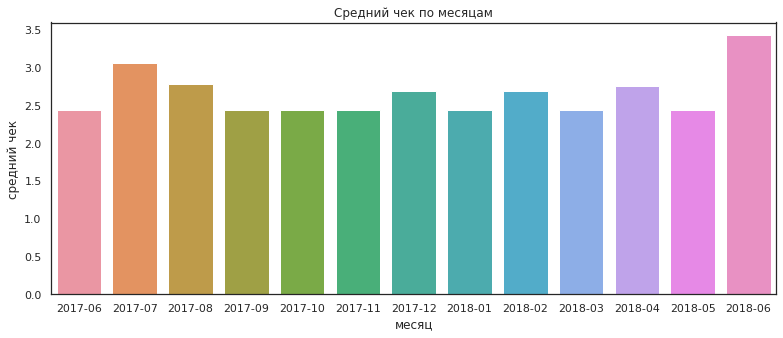

In [39]:
#посмотрим, влияет ли сезонность на средний чек:

mean_revenue_monthly = orders.pivot_table(index ='order_month', values = 'Revenue', aggfunc='median').reset_index()
mean_revenue_monthly['order_month'] = mean_revenue_monthly['order_month'].dt.strftime('%Y-%m')

fig, ax = pyplot.subplots(figsize=(13, 5))
sns.barplot(x='order_month', y='Revenue', data=mean_revenue_monthly)

ax.set_title('Средний чек по месяцам')
ax.set(xlabel='месяц', ylabel='средний чек')

Разница в среднем чеке по месяцам небольшая, однако, тут видно, что средний чек выше в летние месяцы. Скорее всего, это связано с тем, что летом чаще проводятся концерты и фестивали, билеты на которые стоят недешево. Поэтому, хоть пользователи менее активны в этот период, они готовы потратить деньги на Пикник Афиши и/или Park Live :)


2.2.4 Сколько денег приносят? (LTV)

Посчитаем LTV в разрезе рекламных источников

In [40]:
#месяц первой покупки каждого покупателя через каждый источник :

first_orders = source_orders.groupby(['Uid', 'source_id']).agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['Uid','source_id', 'first_order_month']
first_orders.head()

,Uid,source_id,first_order_month
0,1575281904278712,10,2017-06-01
1,2551852515556206,5,2017-11-01
2,3077748354309989,3,2018-03-01
3,3605148382144603,2,2017-09-01
4,3605148382144603,5,2017-09-01


In [41]:
# количество новых покупателей за каждый месяц:

cohort_sizes = first_orders.groupby(['source_id','first_order_month']).agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['source_id','first_order_month', 'n_buyers']
cohort_sizes.head()

,source_id,first_order_month,n_buyers
0,1,2017-06-01,253
1,1,2017-07-01,242
2,1,2017-08-01,153
3,1,2017-09-01,311
4,1,2017-10-01,475


In [42]:
#Построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами:

orders_new = pd.merge(source_orders,first_orders, on=['Uid', 'source_id'])
cohorts = orders_new.groupby(['source_id','first_order_month','order_month']).agg({'Revenue': 'sum'}).reset_index()
cohorts.head()

,source_id,first_order_month,order_month,Revenue
0,1,2017-06-01,2017-06-01,1264.19
1,1,2017-06-01,2017-07-01,29.63
2,1,2017-06-01,2017-08-01,54.79
3,1,2017-06-01,2017-09-01,82.28
4,1,2017-06-01,2017-10-01,75.42


In [43]:
# Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц

report = pd.merge(cohort_sizes, cohorts, on=['source_id','first_order_month'])
report.head()

,source_id,first_order_month,n_buyers,order_month,Revenue
0,1,2017-06-01,253,2017-06-01,1264.19
1,1,2017-06-01,253,2017-07-01,29.63
2,1,2017-06-01,253,2017-08-01,54.79
3,1,2017-06-01,253,2017-09-01,82.28
4,1,2017-06-01,253,2017-10-01,75.42


In [44]:
#посчитаем среднее LTV для каждого источника

margin_rate = 1
    
report['gp'] = report['Revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report['ltv'] = report['gp'] / report['n_buyers']

for source_id in report['source_id'].unique().tolist():
    ltv_output = report[report['source_id'] == source_id].pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round()
    print('LTV рекламного источника',source_id)
    print(ltv_output.cumsum(axis=1).mean(axis=0)) 
    print()

LTV рекламного источника 1
age
0      5.333333
1      5.818182
2      5.800000
3      5.888889
4      6.000000
5      6.285714
6      7.000000
7      7.400000
8      7.500000
9      8.333333
10     9.000000
11    10.000000
dtype: float64

LTV рекламного источника 2
age
0     5.583333
1     6.909091
2     7.500000
3     8.333333
4     9.000000
5     9.857143
6     9.000000
7     7.600000
8     8.000000
9     7.333333
10    7.500000
11    6.000000
dtype: float64

LTV рекламного источника 3
age
0     4.083333
1     4.222222
2     4.375000
3     4.428571
4     4.142857
5     4.333333
6     4.400000
7     4.666667
8     4.500000
9     5.000000
10    4.000000
11    3.000000
dtype: float64

LTV рекламного источника 4
age
0     4.076923
1     4.181818
2     4.285714
3     4.250000
4     4.285714
5     4.285714
6     4.333333
7     4.666667
8     4.500000
10    4.000000
11    4.000000
dtype: float64

LTV рекламного источника 5
age
0     4.833333
1     4.909091
2     4.900000
3     4.888889
4   

Пользователи рекламных источников 1 и 5 с каждым месяцем приносят все больше прибыли.

Пользователи рекламных источников 2 до 7 месяца увеличивает траты, а после начинает тратить меньше

Пользователи 3,4,9,10 рекламных источников в среднем каждый месяц приносят одинаковое количество денег. 

Пользователи рекламного источника 7 совершают разовые покупки в 0 месяц и дальше не покупают. 

Больше всего покупают пользователи первого и второго источников

Посчитаем LTV всей кампании в целом:

In [45]:
total_first_orders = source_orders.groupby(['Uid']).agg({'order_month': 'min'}).reset_index()
total_first_orders.columns = ['Uid', 'first_order_month']

total_cohort_sizes = total_first_orders.groupby(['first_order_month']).agg(
                                                        {'Uid': 'nunique'}).reset_index()
total_cohort_sizes.columns = ['first_order_month', 'n_buyers']

total_orders_new = pd.merge(source_orders,total_first_orders, on=['Uid'])
total_cohorts = total_orders_new.groupby(['first_order_month','order_month']).agg(
                                                        {'Revenue': 'sum'}).reset_index()

total_report = pd.merge(total_cohort_sizes, total_cohorts, on=['first_order_month'])

margin_rate = 1
    
total_report['gp'] = total_report['Revenue'] * margin_rate
total_report['age'] = (total_report['order_month'] - total_report['first_order_month']) / np.timedelta64(1, 'M')
total_report['age'] = total_report['age'].round().astype('int')

total_report['ltv'] = total_report['gp'] / total_report['n_buyers']

total_ltv_output = total_report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)
   
total_ltv_output.cumsum(axis=1).mean(axis=0)

age
0     4.486923
1     4.850909
2     5.062000
3     5.536667
4     5.853750
5     6.204286
6     6.381667
7     6.732000
8     7.190000
9     6.643333
10    7.110000
11    7.540000
dtype: float64

В среднем, прибыль от среднего пользователя растет до 8 месяца (до марта) включительно, а после снижается. 

Построим тепловую карту по LTV:

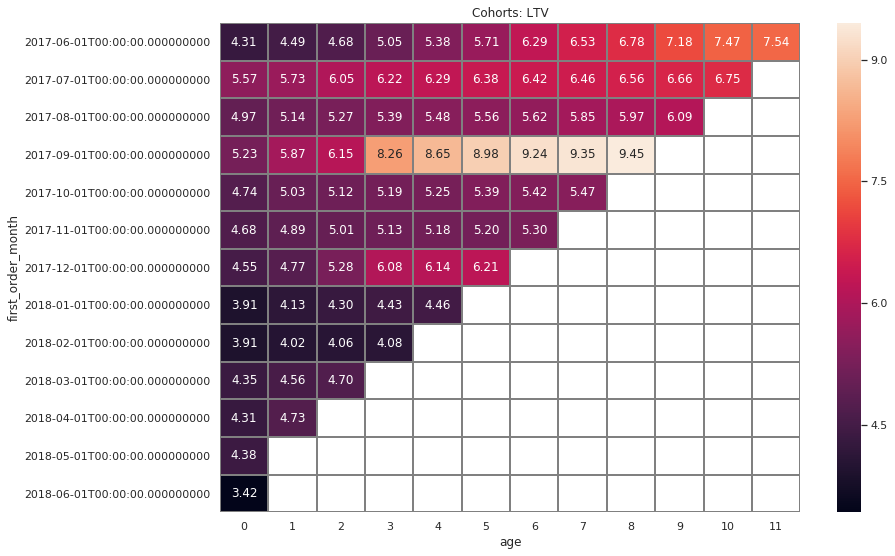

In [46]:
#построим тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: LTV')
sns.heatmap(total_ltv_output.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 

По графику видно, что пользователи покупают в первый месяц, а потом почти не делают повторных покупок - выручка на графике почти не растет. Повтороно покупают только пользователи 1,4 и 7 когорт.

In [47]:
total_report

,first_order_month,n_buyers,order_month,Revenue,gp,age,ltv
0,2017-06-01,1813,2017-06-01,7813.96,7813.96,0,4.309961
1,2017-06-01,1813,2017-07-01,323.66,323.66,1,0.178522
2,2017-06-01,1813,2017-08-01,346.71,346.71,2,0.191236
3,2017-06-01,1813,2017-09-01,667.19,667.19,3,0.368003
4,2017-06-01,1813,2017-10-01,599.40,599.40,4,0.330612
...,...,...,...,...,...,...,...
74,2018-03-01,2816,2018-05-01,383.05,383.05,2,0.136026
75,2018-04-01,1780,2018-04-01,7672.73,7672.73,0,4.310522
76,2018-04-01,1780,2018-05-01,746.33,746.33,1,0.419287
77,2018-05-01,2366,2018-05-01,10354.18,10354.18,0,4.376238


In [48]:
total_ltv_output.cumsum(axis=1)[5].mean()

6.204285714285713

#### 2.3 Маркетинг

2.3.1 Сколько денег потратили? Всего / на каждый источник / по времени

In [49]:
#выделим месяц расходов
costs['month'] = costs['dt'].astype('datetime64[M]') 

In [50]:
#найдем, сколько всего денег потратили: 

print('Всего потратили на маркетинг:', round(sum(costs['costs']), 2))

Всего потратили на маркетинг: 329131.62


[Text(0, 0.5, 'затраты'), Text(0.5, 0, 'рекламный источник')]

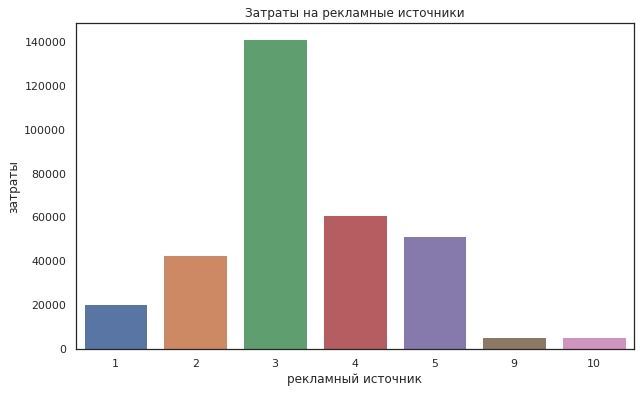

In [51]:
#на каждый источник: 

source_costs = costs.groupby('source_id').sum()

fig, ax = pyplot.subplots(figsize=(10, 6))
sns.barplot(x=source_costs.index, y='costs', data=source_costs)

ax.set_title('Затраты на рекламные источники')
ax.set(xlabel='рекламный источник', ylabel='затраты')

Больше всего было потрачено на 3 источник - примерно 140 тыс. На втором месте по затратам 4 источник - 60 тыс. 
Меньше всего потратили на 9 и 10 источники - примерно по 5 тыс. 

Однако, как мы помним, в таблице visits были еще 6, 7 и 8 источники. Получается, на продвижение через эти источники денег не тратили. Возможно, это прямые заходы и переходы из поисковых систем.

[Text(0, 0.5, 'Затраты'), Text(0.5, 0, 'Месяц')]

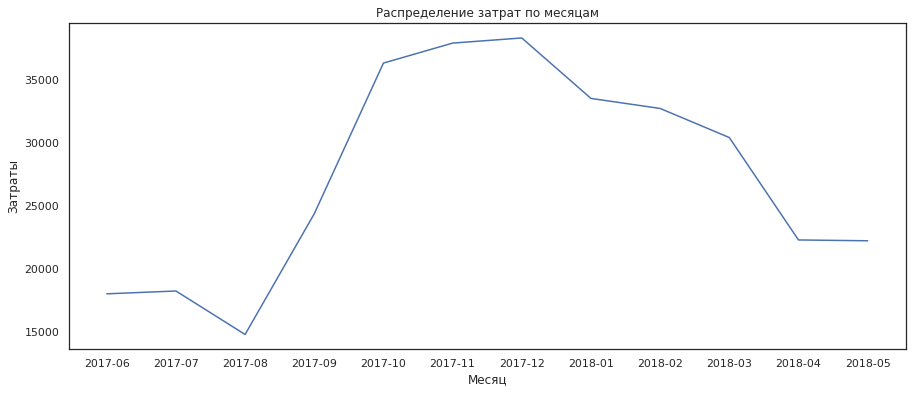

In [52]:
#по времени
monthly_costs = costs.groupby('month').agg({'costs':'sum'}).reset_index()
monthly_costs['month'] = monthly_costs['month'].dt.strftime('%Y-%m')

fig, ax = pyplot.subplots(figsize=(15, 6))
sns.lineplot(x='month', y='costs', data=monthly_costs)

ax.set_title('Распределение затрат по месяцам')
ax.set(xlabel='Месяц', ylabel='Затраты')

На графике четко видно, что затраты на маркетинг увеличиваются к октябрю и начинают снижаться в январе. 
Напомним, что когда мы исследовали посещаемость ресурса и количество покупок, мы обнаружили, что в зимние месяцы пользователи более активны: чаще заходят на сайт и чаще покупают. Однако средний чек выше летом. 
Из этого можно предположить, что если бы летом затраты на маркетинг сохранялись на уровне зимы, можно было бы значительно увеличить средний чек, активность и количество покупок.

2.3.2 Сколько стоило привлечение одного покупателя из каждого источника?

[Text(0, 0.5, 'CAC'), Text(0.5, 0, 'рекламный источник')]

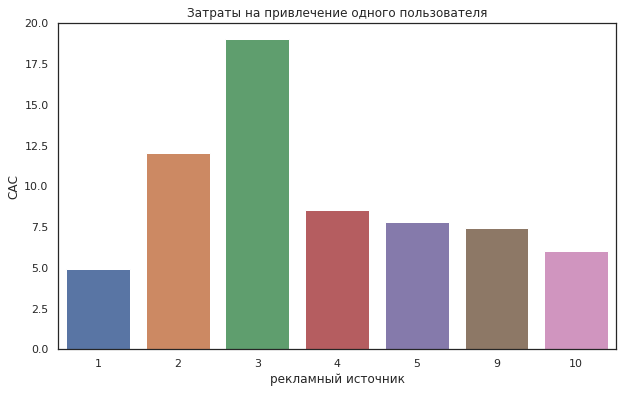

In [53]:
#Посчитаем CAC для всех источников:

monthly_source_costs = costs.groupby(['month', 'source_id']).agg({'costs':'sum'}).reset_index()
report_new = pd.merge(report, monthly_source_costs, left_on=['source_id','first_order_month'], right_on=['source_id','month'])
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

cac_output = report_new.pivot_table(
        index='source_id',  
        values='cac', 
        aggfunc='mean')

fig, ax = pyplot.subplots(figsize=(10, 6))
sns.barplot(x=cac_output.index, y='cac', data=cac_output)

ax.set_title('Затраты на привлечение одного пользователя')
ax.set(xlabel='рекламный источник', ylabel='CAC')

Самые дорогие пользователи у 3 источника, это объясняет, почему на него был выделен самый большой бюджет. В общем, бюджеты на каждый источник пропорциональны затратам на привлечение одного пользователя. 

Посчитаем CAC каждого месяца:

                         cac
first_order_month           
2017-06             9.936569
2017-07            11.204294
2017-08            12.917502
2017-09            11.467722
2017-10            10.022870
2017-11            11.628184
2017-12            10.768789
2018-01            12.250921
2018-02            11.122716
2018-03            10.800877
2018-04            12.522124
2018-05             9.393183


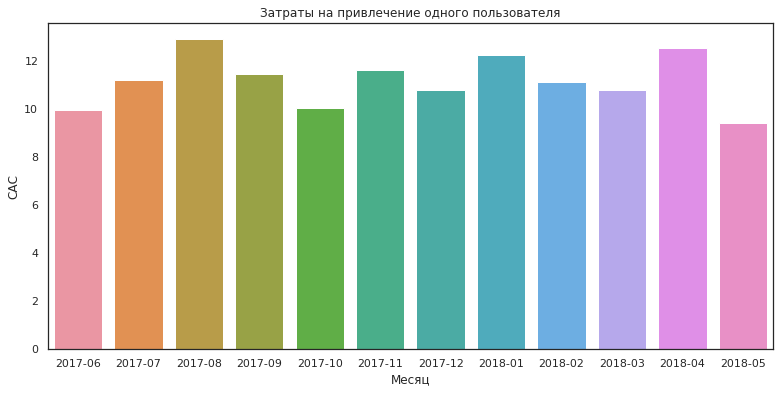

In [54]:
total_monthly_source_costs = costs.groupby(['month']).agg({'costs':'sum'}).reset_index()
total_report_new = pd.merge(total_report, total_monthly_source_costs, left_on=['first_order_month'], right_on=['month'])
total_report_new['cac'] = total_report_new['costs'] / total_report_new['n_buyers']
total_report_new['first_order_month'] = total_report_new['first_order_month'].dt.strftime('%Y-%m')
total_cac_output = total_report_new.pivot_table(
        index='first_order_month',  
        values='cac', 
        aggfunc='mean')

fig, ax = pyplot.subplots(figsize=(13, 6))
sns.barplot(x=total_cac_output.index, y='cac', data=total_cac_output)

ax.set_title('Затраты на привлечение одного пользователя')
ax.set(xlabel='Месяц', ylabel='CAC')

print(total_cac_output)

Посчитаем средний CAC:

In [55]:
print('Средний CAC:', round(total_cac_output.mean()[0], 2))

Средний CAC: 11.17


Самые дорогие пользователи получились в авгусе 2017, в январе и в апреле 2018. 

Самые дешевые в июне, октябре 2017 и мае 2018.

Средняя стоимость пользователя - 11.17.

Даже не считая ROMI можно сказать, что расходы на маркетинг почти не окупаются.

2.3.3 На сколько окупились расходы? (ROI)

In [56]:
#Посчитаем ROMI для всех когорт каждого источника и посмотрим, 
#сколько месяцев нужно каждой когорте каждого источника, чтобы окупить маркетинговые затраты
report_new['romi'] = report_new['ltv'] / report_new['cac']

for source_id in report_new['source_id'].unique().tolist():
    romi_output = report_new[report_new['source_id'] == source_id].pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean').round()
    print('ROMI рекламного источника',source_id)
    print(romi_output.cumsum(axis=1).mean(axis=0)) 
    print()

ROMI рекламного источника 1
age
0     1.083333
1     1.090909
2     1.100000
3     1.111111
4     1.125000
5     1.142857
6     1.166667
7     1.200000
8     1.250000
9     1.333333
10    1.500000
11    1.000000
dtype: float64

ROMI рекламного источника 2
age
0     0.500000
1     0.545455
2     0.600000
3     0.666667
4     0.750000
5     0.857143
6     0.833333
7     0.800000
8     0.750000
9     0.666667
10    1.000000
11    1.000000
dtype: float64

ROMI рекламного источника 3
age
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
dtype: float64

ROMI рекламного источника 4
age
0     0.750000
1     0.727273
2     0.714286
3     0.625000
4     0.571429
5     0.571429
6     0.500000
7     0.333333
8     0.250000
10    0.000000
11    0.000000
dtype: float64

ROMI рекламного источника 5
age
0     0.833333
1     0.818182
2     0.800000
3     0.777778
4     0.750000
5     0.857143
6     0.833333
7     1.000000
8     1.000

Затраты на 1 источник окупаются сразу.

Затраты на 2 источник окупаются почти через год - на 10 месяце.

Затраты на 5 источник окупаются в 7 месяц.

Затраты на 3, 4, 9, 10 источники не окупаются вовсе.

###  Шаг 3. Выводы и рекомендации

**Подведем итоги:**

1) Сколько людей пользуются в день, неделю, месяц?
    - В среднем Я.Афишей пользуются 907 человек в день, 5716 в неделю, 23228 в месяц.
    - Большинство пользователей заходят на ресурс с десктопов. 
    - Независимо от исследуемого периода, большая часть пользователей пришла из рекламных источников 4, 3, 5. 
    - Меньше всего пользователей привели источники 6 и 7

2) Сколько сессий в день?

    - Если рассматривать общую картину, то среднее количество сессий в день - 1003. Большая их часть совершается на десктопе. Однако, если смотреть на динамику среднего количества сессий в день по месяцам, то видно, что с осени активность пользователей растет - они чаще заходят на Я.Афишу. Пользовательская активность достигает пика в декабре и к весне она снова постепенно снижается.

3) Сколько длится одна сессия?

    - Медианная длительность сессии - 300 секунд, это 5 минут. 
    - Но чаще всего сессия длится 1 минуту. 
    - Из этого можно сделать вывод, что люди не проводят на сайте много времени - скорее всего заходят целенаправленно. Смущает, что 1 минута - самая распространненная длительность сессии. Сложно за минуту выбрать куда пойти и, тем более,купить билет. Могут это быть боты? Или сервис неудобный? 
    
4) Как часто люди возвращаются?

    - Процент вернувшихся пользователей в каждой когорте очень низкий: более 90% пользователей не возвращаются. Вероятно, пользователи приходили ради конкретного мероприятия, а потом возвращались только те, кто в принципе часто ходит по выставкам/концертам и тд. Или, возможно, дело в том, что в 2017-2018 годах сервис был не очень удобен для планирования досуга.
    
5) Когда люди начинают покупать?
    - В среднем люди начинают покупать через 16 минут после первой сессии. Это говорит о том, что пользователи целенаправленно заходят на сайт. 
6) Сколько раз покупают за период?
    - В среднем в месяц пользователи делают по одной покупке. Вероятно, большинство людей в приципе ходят на концерты/в музеи и тд довольно редко. Самые активные как раз будут составлять тот небольшой процент вернувшихся из пункта 4.
    - В количестве покупок и тут наблюдается сезонность: больше всего покупают осенью и зимой - в месяц выходит по 5-6 тыс заказов 
    - Чаще всех покупали пользователи трех источников: 4, 5, 3. Реже всех - пользователи 7, 9, 10 источников

7) Какой средний чек?
    - Средний чек - 5.0
    - Среднее количество заказов на одного пользователя: 1.0
    - Разница в среднем чеке по месяцам небольшая, однако, тут видно, что средний чек выше в летние месяцы. Скорее всего, это связано с тем, что летом чаще проводятся концерты и фестивали, билеты на которые стоят недешево. Поэтому, хоть пользователи менее активны в этот период, они готовы потратить деньги на Пикник Афиши и/или Park Live :)

8) Сколько денег приносят? (LTV)
    - В среднем, прибыль от среднего пользователя растет до 8 месяца (до марта) включительно, а после снижается.
    - Пользователи рекламных источников 1 и 5 с каждым месяцем приносят все больше прибыли.
    - Пользователи рекламного источника 2 до 7 месяца увеличивает траты, а после начинает тратить меньше
    - Пользователи 3,4,9,10 рекламных источников в среднем каждый месяц приносят одинаковое количество денег. 
    - Пользователи рекламного источника 7 совершают разовые покупки в 0 месяц и дальше не покупают. 
    - Больше всех покупают пользователи первого и второго источников
    
9) Сколько денег потратили? Всего / на каждый источник / по времени
    - Больше всего было потрачено на 3 источник - примерно 140 тыс. На втором месте по затратам 4 источник - 60 тыс. Меньше всего потратили на 9 и 10 источники - примерно по 5 тыс. Однако, как мы помним, в таблице visits были еще 6, 7 и 8 источники. Получается, на продвижение через эти источники денег не тратили. Возможно, это прямые заходы и переходы из поисковых систем.
    - На графике четко видно, что затраты на маркетинг увеличиваются к октябрю и начинают снижаться в январе. Напомним, что когда мы исследовали посещаемость ресурса и количество покупок, мы обнаружили, что в зимние месяцы пользователи более активны: чаще заходят на сайт и чаще покупают. Однако средний чек выше летом. Из этого можно предположить, что если бы летом затраты на маркетинг сохранялись на уровне зимы, можно было бы значительно увеличить средний чек, активность и количество покупок.
    
10) Сколько стоило привлечение одного покупателя из каждого источника?
    - Самые дорогие пользователи у 3 источника, это объясняет, почему на него был выделен самый большой бюджет. В общем, бюджеты на каждый источник пропорциональны затратам на привлечение одного пользователя. 
    - Самые дорогие пользователи получились в авгусе 2017, в январе и в апреле 2018. 
    - Самые дешевые в июне, октябре 2017 и мае 2018.

11) На сколько окупились расходы? (ROI)
    - Затраты на 1 источник окупаются сразу.
    - Затраты на 2 источник окупаются почти через год - на 10 месяце.
    - Затраты на 5 источник окупаются в 7 месяц.
    - Затраты на 3, 4, 9, 10 источники не окупаются вовсе.
    
    

**Рекомендации:**

1) Имеет смысл перераспределить часть бюджета с 3 и 4 источников на 1 и 5, так как пользователи с 1 и 5 источников склонны с каждым месяцем приносить все больше денег. Кроме того, затраты на эти источники пере за первые полгода почти окупаются. 

2) Возможно, стоит отказаться от 9 и 10 источников в пользу более прибыльных: 1, 2, 5. Источники 9 и 10 - почти не приносят прибыли и не окупаются. 

3) Стоит проводить более активные РК в теплые месяцы, когда проводится больше концертов и фестивалей - в этот период и ради крупных событий пользователи готовы тратить больше денег -> увеличивается средний чек. 

4) Не стоит забывать про источники 6, 7, 8 - они бесплатные, преположительно это трафик из поиска. Это значит, эти источники можно использовать для увеличения общей выручки и покрытия расходов: возможно надо поработать над тем, чтобы при поиске определенного мероприятия сайт Я.Афиши показывался чаще, чем сейчас.

5) Люди мало пользуются мобильной версией сайта - надо выяснить почему, возможность, есть проблема, и решив ее, можно увеличить посещаемость и выручку.

6) Посмотреть, что делают люди, которые проводят на сайте 1 минуту - может, с сайтом что-то не так? Или рекламные ссылки ведут не на то мероприятие?

7) Так как в основном люди покупают 1 раз и больше не возвращаются, может, имеет смысл использовать ремаркетинг на похожие мероприятия?
